# 환경 세팅

In [2]:
import os
from keras.preprocessing.image import load_img, img_to_array, save_img # 경로 설정을 위한 library

import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 뉴럴 스타일 트랜스퍼
---
* 이미지에 새로운 스타일을 접목시키는 생성모델

In [3]:
os.chdir("/Users/arnorfati/downloads/")

In [4]:
import cv2
import matplotlib.pyplot as plt

In [8]:
content = cv2.imread("하나은행.jpg", cv2.IMREAD_ANYCOLOR)
style = cv2.imread("모네스타일.jpg", cv2.IMREAD_ANYCOLOR)
style = style[10:545,20:680]

In [9]:
style = cv2.imread("모네스타일.jpg", cv2.IMREAD_ANYCOLOR)

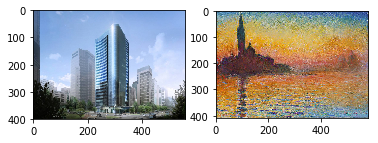

In [10]:
plt.subplot(121)
plt.imshow(cv2.cvtColor(content, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(style, cv2.COLOR_BGR2RGB))

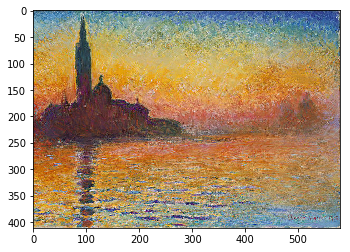

In [9]:
# plt.subplot(121)
# plt.imshow(cv2.cvtColor(content, cv2.COLOR_BGR2RGB))
# # plt.imshow(content,cv2.COLOR_BGR2RGB)
# plt.subplot(122)
plt.imshow(cv2.cvtColor(style, cv2.COLOR_BGR2RGB))

In [68]:
os.chdir("/Users/arnorfati/Documents/Data/keras_dataset/")
cv2.imwrite('aaa.png', content)
cv2.imwrite('bbb.png', style)

True

In [71]:
# 변환하려는 이미지 경로
target_image_path = './aaa.png'
# 스타일 이미지 경로
style_reference_image_path = './bbb.png'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)


In [73]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [74]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

In [75]:

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 결합
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 생성
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)


# ! pip install keras_vggface
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace

# face recognition 모델 로드
# vggface = VGGFace(model='vgg16') # or VGGFace() as default
# vggface = VGGFace(model='resnet50')
vggface = VGGFace(model='senet50')

print('모델 로드 완료.')

모델 로드 완료.


In [76]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [77]:
# 콘텐츠와 스타일 말고 loss function을 하나더 필요함.... 왠지 모름... 하라니까 일단 함.

def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [78]:
# 핵심!!!!!! 손실에 사용할 layer 매핑.. 디테일한 스타일을 살리려면 스타일 layer에 눈, 코, 입 같은 특징을 잡아내는 conv를 찾아야 함..

# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.2 # 높이면 style과 더 유사하게 됨..
content_weight = 0.025 # 높이면 content와 더 유사하게 됨


# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [79]:
# 논문에 있는거 빼낌..


# 손실에 대한 생성된 이미지의 그래디언트를 계산
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [81]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼쳐서 해야 한다는데 그럼 conv net사용하는 의미가 있나?
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)

    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 1744254700.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 369s
반복 횟수: 1
현재 손실 값: 583408600.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 360s
반복 횟수: 2
현재 손실 값: 364631580.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 360s
반복 횟수: 3
현재 손실 값: 286087230.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 363s
반복 횟수: 4
현재 손실 값: 244023060.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 361s
반복 횟수: 5
현재 손실 값: 215413900.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 394s
반복 횟수: 6
현재 손실 값: 197004770.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 359s
반복 횟수: 7
현재 손실 값: 177254350.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 359s
반복 횟수: 8
현재 손실 값: 163181600.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 368s
반복 횟수: 9
현재 손실 값: 146413100.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 370s
반복 횟수: 10
현재 손실 값: 135653360.

In [82]:
from matplotlib import pyplot as plt

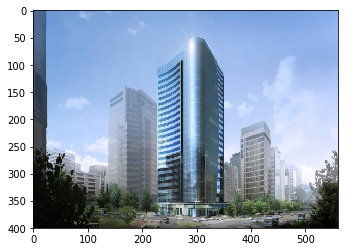

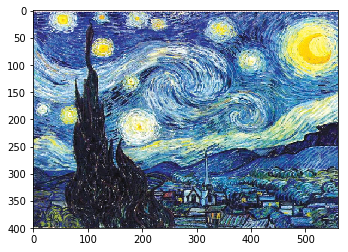

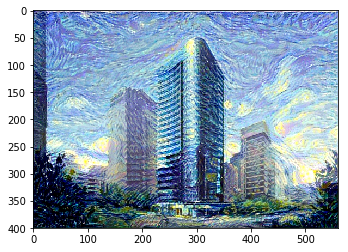

In [83]:
# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()